### Estimating the Regional and Residual Gravity Data using the equivalent layer and a Polynomial Function
###  Here, the equivalent layer has the same area and the same shape of the data
###### This notebook reads synthetic data (synthetic-data.txt) which were previously created by the notebook 
###### Equivalent_Layer_Larissa_Regional.ipynb
###### This notebook estimates the regional component of gravity data and calculates the residual component of the gravity data

###### OBS:  Não consegui ler quando não há regional adicionado. O problema é o typo da variável Regional_Information 

In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.mlab as mlab
import cPickle as pickle
#import datetime
from datetime import datetime
from IPython.display import Markdown as md
from IPython.display import display as dp
import string as st

from __future__ import division
from future.builtins import super

import auxiliary_functions as af
import auxiliary_functions_Larissa_Project as af_L

import fatiando
from fatiando import gridder
from fatiando.mesher import Prism, PointGrid
from fatiando.gridder import regular
from fatiando.gravmag import prism, sphere
from fatiando.gravmag.eqlayer import EQLTotalField
from fatiando.gravmag.eqlayer import EQLGravity
from fatiando.inversion.regularization import Damping, Smoothness2D
from fatiando.inversion.hyper_param import LCurve
from fatiando.vis import mpl, myv
from fatiando.utils import ang2vec, vec2ang, contaminate, dircos
from fatiando.constants import G, SI2MGAL,SI2EOTVOS

C:\Anaconda2\lib\site-packages\fatiando\vis\mpl.py:70: UserWarning: This module will be removed in v0.6. We recommend the use of matplotlib.pyplot module directly. Some of the fatiando specific functions will remain.
  "specific functions will remain.")
C:\Anaconda2\lib\site-packages\fatiando\vis\myv.py:53: UserWarning: This module will be removed in v0.7.
  warnings.warn("This module will be removed in v0.7.")


Executed auxiliary_functions_Larissa_Project.py


In [2]:
from numpy import linalg
from scipy.optimize import nnls
from scipy.sparse import identity
from scipy.sparse import diags
from scipy.stats import norm



In [3]:
def Matrix_Polynomial(x,y,order):
    assert (xp.size == yp.size), 'xp and yp must have the same size '
    assert (order == 1) or (order == 2), ' Create First- or Second-orders polynomials'
    if order == 1:
        B_Poly[:,0] = 1.
        B_Poly[:,1] = x
        B_Poly[:,2] = y
    elif order ==2:
        B_Poly[:,0] = 1.
        B_Poly[:,1] = x
        B_Poly[:,2] = y
        B_Poly[:,3] = x**2
        B_Poly[:,4] = x*y
        B_Poly[:,5] = y**2
               
    return B_Poly
    

In [4]:
notebook_name = 'Read_File_Temp.ipynb'

In [5]:
print("Version of Fatiando a Terra used: {}".format(fatiando.__version__))

Version of Fatiando a Terra used: ac2afbcb2d99b18f145cc1ed40075beb5f92dd5a


In [6]:
with open('../data/model_single.pickle') as f:
        full_model = pickle.load(f)

In [7]:
with open('../data/regular_grid.pickle') as f:
        regular_grid = pickle.load(f)

In [8]:
print regular_grid['shape'][0], regular_grid['shape'][1]

100 80


####  Open data file

In [9]:
with open('../data/synthetic-data.txt') as f:
    for i in range(2):
        f.readline()
    line = f.readline()
    shape = map(int, line.split()[1:])
    print(shape)
    Regional_Information = f.readline()
    print(Regional_Information), type(Regional_Information)  
    if Regional_Information is not None:
        xp, yp, zp, data, Regional, gz = np.loadtxt(f, unpack=True, usecols=[0, 1, 2, 3, 4, 5])                     
    else: 
        xp, yp, zp, gz = np.loadtxt(f, unpack=True, usecols=[0, 1, 2, 3])     
    

[100, 80]
    FIRST-ORDER POLYNOMIAL
<type 'str'>


In [10]:
### Ploting (1) Original Data (2) Regional and (3) Data+Regional

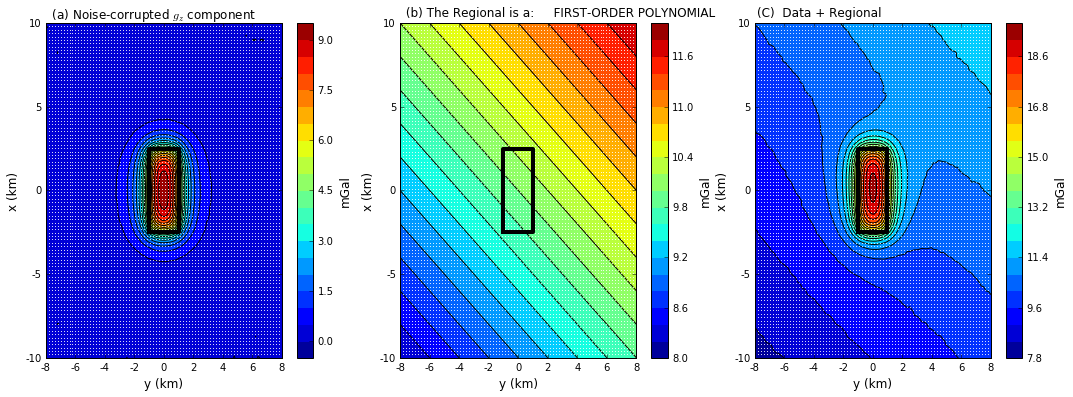

In [11]:
plt.figure(figsize=(18, 6))
unit_handle = 'mGal'

if (Regional_Information is None):
    print 'Data Without Regional Background'
    print '\n No regional map \n '
    af_L.Plot_Onemap(xp, yp, gz, regular_grid['shape'], 
                prism_projection = True, projection_style = '-k', line_width = 4.0,
                model = full_model['projection'], 
                figure_title='Noise-corrupted $g_z$ component', 
                label_x = 'y (km)', label_y = 'x (km)', label_size= 16.0, 
                observations= True, point_style= 'w.', point_size = 1, unit = unit_handle)
elif ('CONSTANT' in Regional_Information):
    print("REGIONAL INFORMATION ADDED TO THE ORIGINAL DATA WAS: {}".format(Regional_Information))
    print '\n'+Regional_Information+'  =  %4.3f \n' %Regional[0]
    print '\n No regional map \n '
    
    af_L.Plot_Twomaps(xp, yp, data, gz, regular_grid['shape'], 
                prism_projection = True, projection_style = '-k', line_width = 4.0,
                model = full_model['projection'], 
                figure_title1 = " (a) Noise-corrupted $g_z$ component", 
                figure_title2 = " (b) Data + Regional - The Regional is a: {}".format(Regional_Information),
                label_x = 'y (km)', label_y = 'x (km)', label_size= 16.0, 
                observations= True, point_style= 'w.', point_size = 1, unit = 'mGal')
elif('FIRST-ORDER POLYNOMIAL' in Regional_Information) or ('SECOND-ORDER POLYNOMIAL' in Regional_Information):
    af_L.Plot_Threemaps(xp, yp, data, Regional, gz, regular_grid['shape'], 
                prism_projection = True, projection_style = '-k', line_width = 4.0,
                model = full_model['projection'], 
                figure_title1 = " (a) Noise-corrupted $g_z$ component", 
                figure_title2 = " (b) The Regional is a: {}".format(Regional_Information),
                figure_title3 = "(C)  Data + Regional",
                label_x = 'y (km)', label_y = 'x (km)', label_size= 12.0, 
                observations= True, point_style= 'w.', point_size = 1, unit = 'mGal')

    

In [12]:
# creating the equivalent Layer x and y coordinates 

xs = np.copy(xp)
ys = np.copy(yp)

#horizontal plane containing the equivalent sources located at plano_fonte 
plano_fonte=400.
zs = np.zeros_like(zp) + plano_fonte

M_source= len(xs)
assert (xs.size == M_source) and (ys.size == M_source) and (zs.size == M_source),  \
                'xs, ys and zs must have the same size defined by M_source'

print 'number of the equivalent sources at the equivalent layer: M_source', M_source

number of the equivalent sources at the equivalent layer: M_source 8000


In [13]:
Npts = len(gz)
print 'number of data: Npts', Npts


print 'number of equivalent sources: M_source', M_source


number of data: Npts 8000
number of equivalent sources: M_source 8000


In [14]:
# Computing the sensitivity matrix by row

A_GZ = np.empty((Npts,M_source),dtype = float)

for i in range(Npts):
    A_GZ[i,:] = af_L.AZ(xp[i], yp[i], zp[i], xs,ys,zs)
   

In [15]:
now = datetime.utcnow().strftime('%d %B %Y %H:%M:%S UTC')

start_time_ATA = datetime.now() 

ATA = np.empty((M_source,M_source),dtype =float)
ATA = np.dot(A_GZ.T, A_GZ)


end_time_ATA  = datetime.now()
print('Duration ATA: {}'.format(end_time_ATA  - start_time_ATA ))  

# Gradient

start_time_ATd = datetime.now() 

ATdo = np.dot(A_GZ.T,gz)

end_time_ATd  = datetime.now()
print('Duration Atd: {}'.format(end_time_ATd  - start_time_ATd ))  

Duration ATA: 0:00:07.757000
Duration Atd: 0:00:00.020000


In [16]:
print type(A_GZ), len(A_GZ)

<type 'numpy.ndarray'> 8000


### Creating a polinomial matrix
$ \bf{B} $

In [17]:
# Creating a polinomial matrix


B_Poly = np.empty((M_source,3),dtype =float)

order_poly = 1
if order_poly == 1:
    B_Poly = np.empty((M_source,3),dtype =float)
elif order_poly == 2:
    B_Poly = np.empty((M_source,6),dtype =float)

B_Poly = Matrix_Polynomial(xs,ys,order_poly)


### Computing: sensitivity matrix multiplied by Polynomial matrix
$ \bf{G} \bf{B} $

In [18]:
GB = np.dot(A_GZ, B_Poly)

# Hessian Matrix without the regularizing function
BTGTGB =  np.dot(GB.T,GB)
# Gradient vector
BGTdo  =  np.dot(GB.T,gz)


In [19]:
#reg_parameter = 0.0000000000000000000001

#reg_parameter = 0.00001

In [20]:
# Normalized Regularizing Parameter 

mi_tkt = 1e-10
reg_parameter = np.trace(BTGTGB)/M_source  *  mi_tkt
print mi_tkt
print reg_parameter

1e-10
3.94368544884e-21


In [21]:
if order_poly == 1:
    n_coef = 3
elif order_poly == 2:
    n_coef = 6

Hessiana  = BTGTGB + diags([reg_parameter], 0, (n_coef,n_coef), format='csr', dtype='float')

c_estimate = linalg.solve(Hessiana,BGTdo)


#### Compute the predicted parameter of the regional (equation 9 PEL)
$  \bf{B} \bf{c} = \bf{p} $

In [22]:
# predicted parameter by the regional equation 9 PEL

print c_estimate

p_regional_estimated = np.dot(B_Poly,c_estimate)

[  1.14227099e+10   1.16734437e+05   1.18893196e+05]


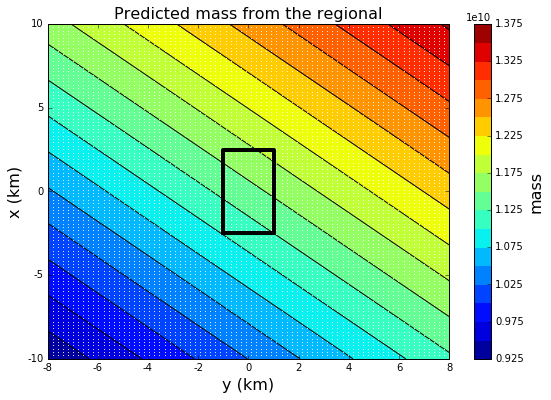

In [23]:
plt.figure(figsize=(9, 6))
unit_handle = 'mass'

af_L.Plot_Onemap(xs, ys, p_regional_estimated, regular_grid['shape'], 
                prism_projection = True, projection_style = '-k', line_width = 4.0,
                model = full_model['projection'], 
                figure_title='Predicted mass from the regional', 
                label_x = 'y (km)', label_y = 'x (km)', label_size= 16.0, 
                observations= True, point_style= 'w.', point_size = 1, unit = unit_handle)

#### Compute the predicted Regional gravity data $ \bf{g^R} $  by using equation 14 PEL
$  \bf{GB} \bf{c} = \bf{g^R} $

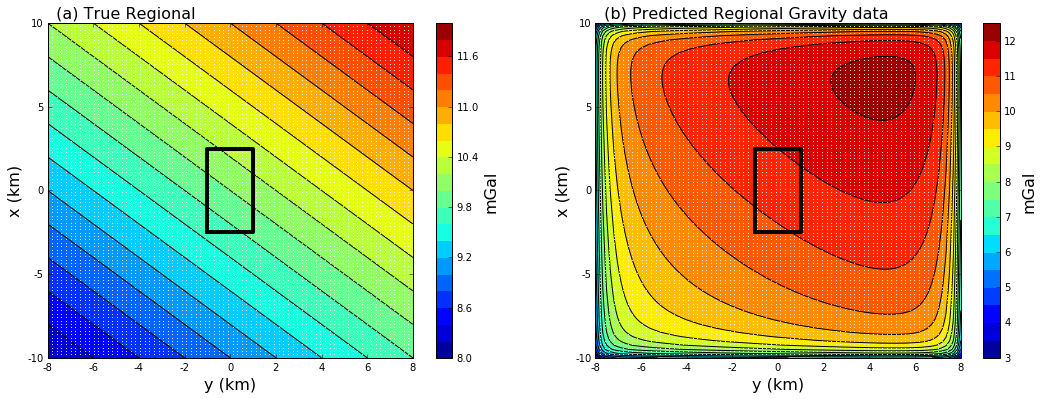

In [24]:
# Compute the predicted Regional gravity data by using equation 14 PEL

predicted_gravity_regional = np.dot(GB,c_estimate)


plt.figure(figsize=(18, 6))
unit_handle = 'mGal'

af_L.Plot_Twomaps(xp, yp, Regional, predicted_gravity_regional, regular_grid['shape'], 
                prism_projection = True, projection_style = '-k', line_width = 4.0,
                model = full_model['projection'], 
                figure_title1 = " (a) True Regional ",
                figure_title2 = " (b) Predicted Regional Gravity data",
                label_x = 'y (km)', label_y = 'x (km)', label_size= 16.0, 
                observations= True, point_style= 'w.', point_size = 1, unit = 'mGal')

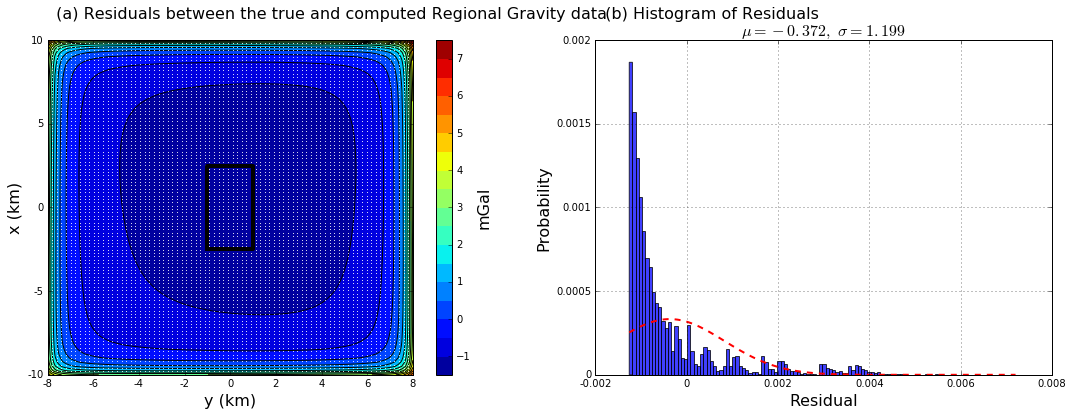

In [25]:
plt.figure(figsize=(18, 6))
unit_handle = 'mGal'
af_L.Plot_Onemap_Histog(xp, yp, Regional - predicted_gravity_regional, regular_grid['shape'], 
                prism_projection = True, projection_style = '-k', line_width = 4.0,
                model = full_model['projection'], 
                figure_title1 = " (a) Residuals between the true and computed Regional Gravity data ",
                figure_title2 = " (b) Histogram of Residuals ",
                label_x = 'y (km)', label_y = 'x (km)', label_size= 16.0, 
                observations= True, point_style= 'w.', point_size = 1, unit = 'mGal')
    
   

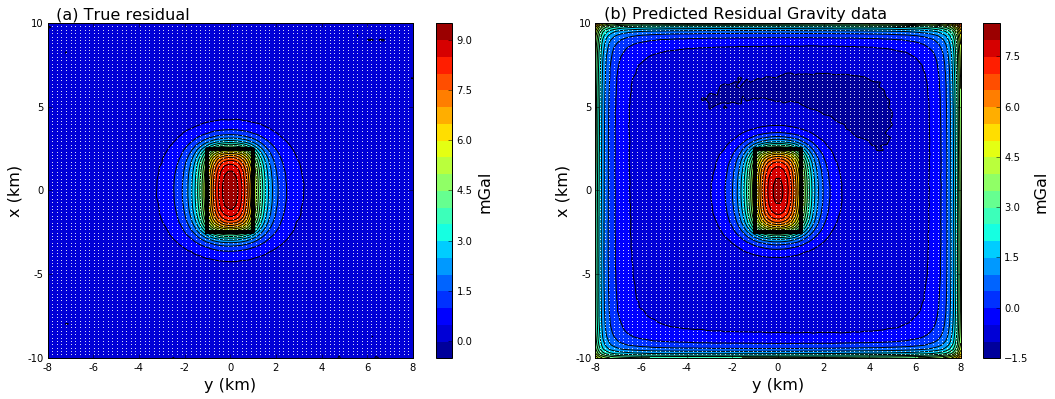

In [26]:
# Compute the Residual = Observed - Predicted gravity data by using equation 14 PEL

Residual_gravity = gz - predicted_gravity_regional 


plt.figure(figsize=(18, 6))
unit_handle = 'mGal'

af_L.Plot_Twomaps(xp, yp, data, Residual_gravity, regular_grid['shape'], 
                prism_projection = True, projection_style = '-k', line_width = 4.0,
                model = full_model['projection'], 
                figure_title1 = " (a) True residual ",
                figure_title2 = " (b) Predicted Residual Gravity data",
                label_x = 'y (km)', label_y = 'x (km)', label_size= 16.0, 
                observations= True, point_style= 'w.', point_size = 1, unit = 'mGal')

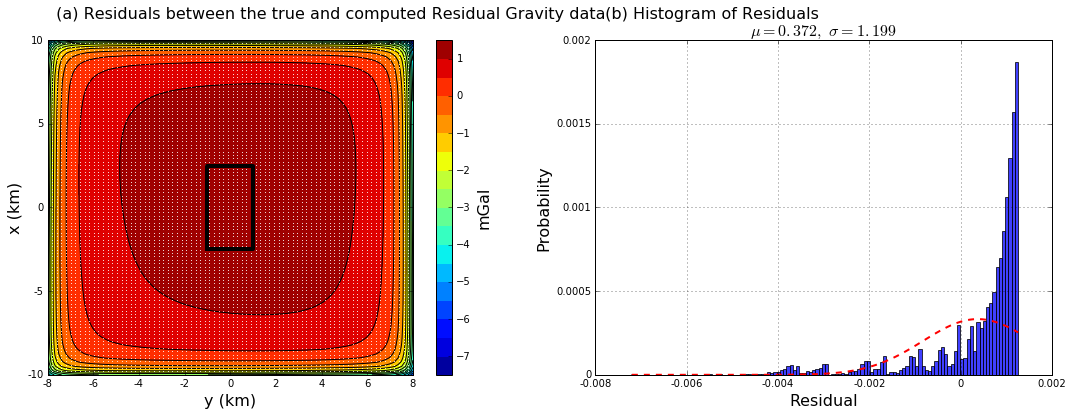

In [27]:
plt.figure(figsize=(18, 6))
unit_handle = 'mGal'
af_L.Plot_Onemap_Histog(xp, yp, data - Residual_gravity, regular_grid['shape'], 
                prism_projection = True, projection_style = '-k', line_width = 4.0,
                model = full_model['projection'], 
                figure_title1 = " (a) Residuals between the true and computed Residual Gravity data",
                figure_title2 = " (b) Histogram of Residuals ",
                label_x = 'y (km)', label_y = 'x (km)', label_size= 16.0, 
                observations= True, point_style= 'w.', point_size = 1, unit = 'mGal')
    